## Sea Surface Temperature Data

### Created by Yuying Liu, 11/09/2019

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

spatial:  127 x 255
temporal:  451


Text(0.5, 1.0, 'sampled snapshot')

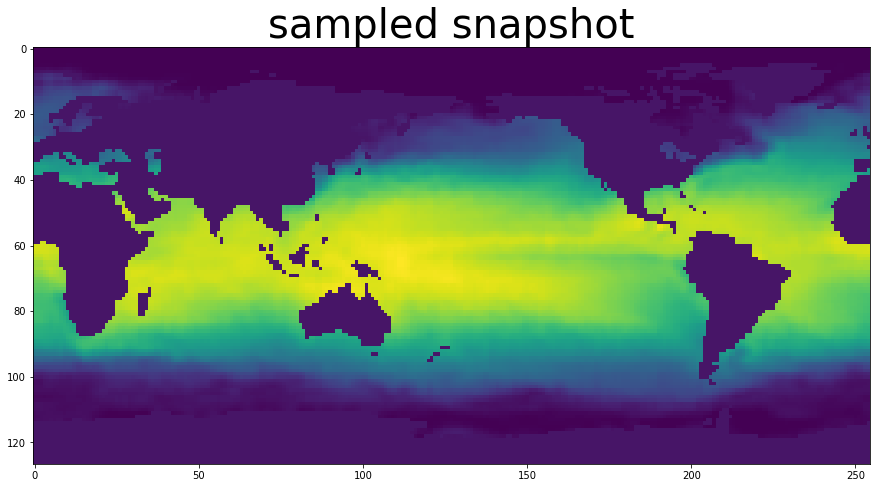

In [2]:
# load and viz data
# Note: download dataset at https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html
sst_mask = np.load('../data/npy/sst.mnmean.mask.npy')

nt, nx, ny = sst_mask.shape
print('spatial: ', nx, 'x', ny)
print('temporal: ', nt)

plt.figure(figsize=(15,8))
plt.imshow(sst_mask[0, :, :])
plt.title('sampled snapshot',fontsize=40)

### MrCAE

In [3]:
# init model & load data
map_path = '../data/npy/mask_w1.npy'
data_path = '../data/npy/sst.mnmean.mask.npy'
model_path = '../model/sst/'
result_path = '../result/sst/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=4, map_path=map_path)

In [ ]:
# # training
# archs = [[1,2,3,4,5],[1,3,5,7,9],[1,4,7,10,13],[1,6,11,16,21]]
# tols = [0.04, 0.02, 0.01, 0.005]
# net.train_net(archs=archs, dataset=dataset, max_epoch=4000, batch_size=350, tols=tols, activation=torch.nn.Sequential(), 
#               w=0.5, model_path=model_path, result_path=result_path, std=0.01, verbose=2)


### Results

In [5]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name), map_location='cpu')

model names: model_L{level}_{index}
model_L0_0
model_L0_1
model_L0_2
model_L1_0
model_L1_1
model_L1_2


/usr/local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


model_L2_0
model_L2_1
model_L2_2
model_L2_3
model_L2_4
model_L3_0
model_L3_1
model_L3_2
model_L3_3
model_L3_4


dict_keys(['0', '1', '2'])
dict_keys(['0', '1', '2'])
dict_keys(['0', '1', '2', '3', '4'])
dict_keys(['0', '1', '2', '3', '4'])


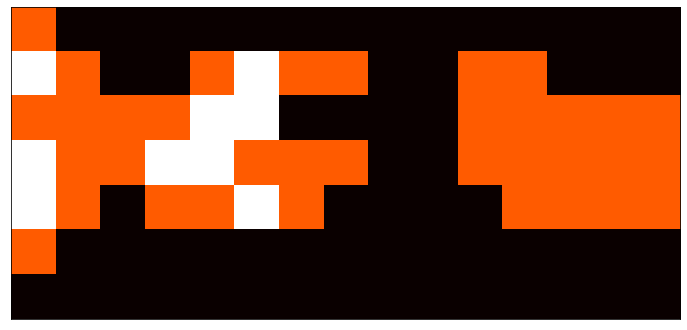

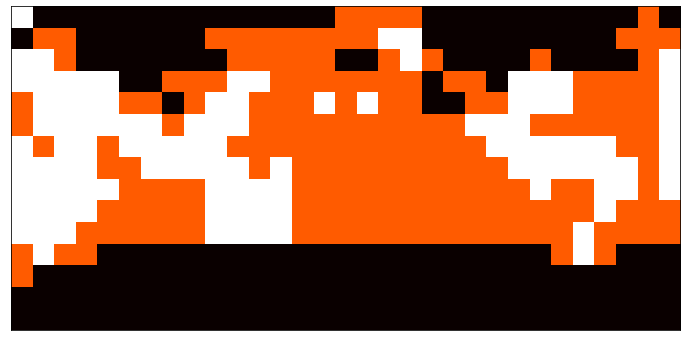

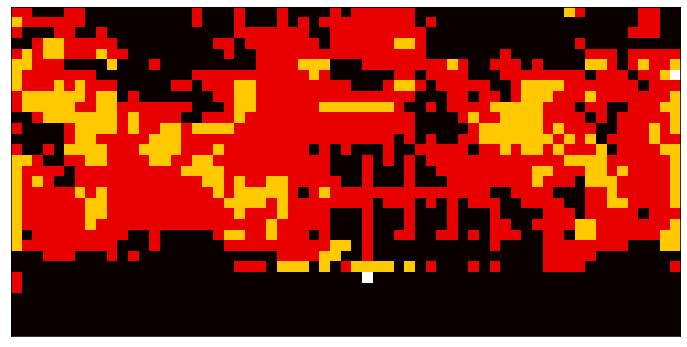

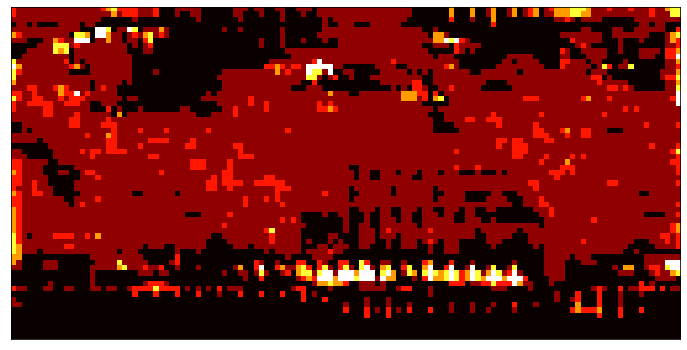

In [7]:
# choose the finest model
model = models['model_L3_4']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(4):
    print(model.resolved_maps[str(i)].keys())
    
for i in range(4):
    level_maps = model.resolved_maps[str(i)]
    for key in level_maps.keys():
        if key == '0':
            intensities = (1 - level_maps[key])
        else:
            intensities += (1 - level_maps[key])
    file_name = 'L{}.png'.format(i)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(intensities.cpu().detach().numpy(), cmap='hot')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig(os.path.join(result_path, file_name))

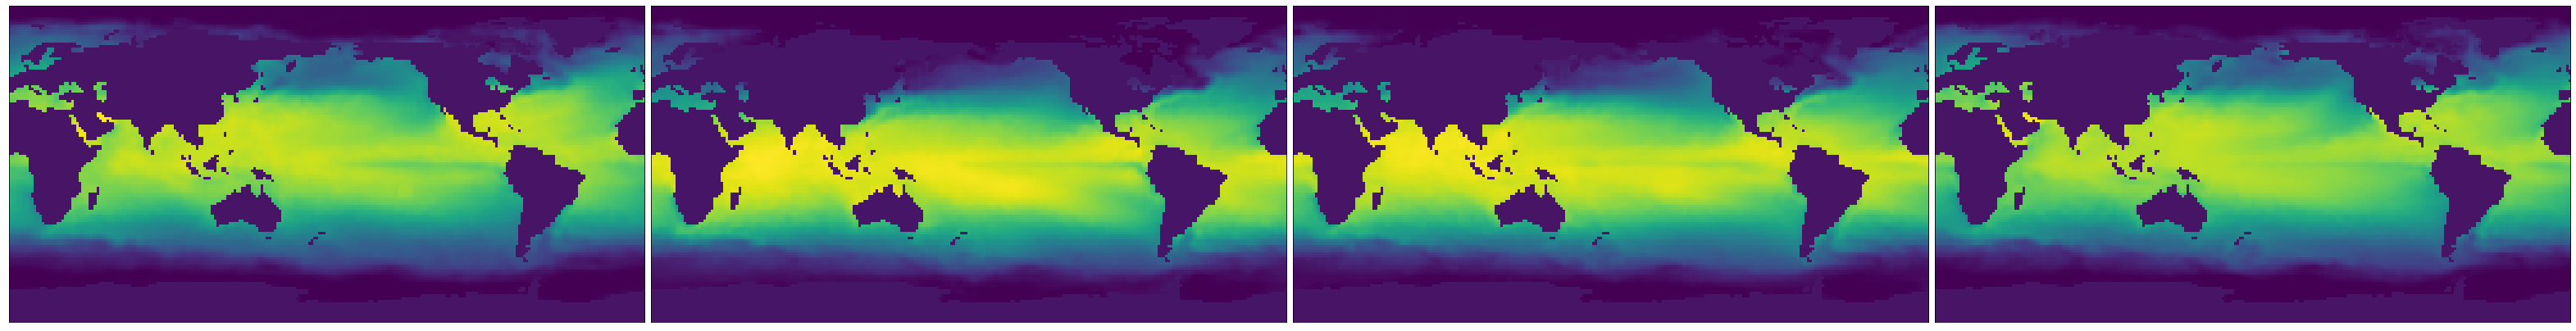

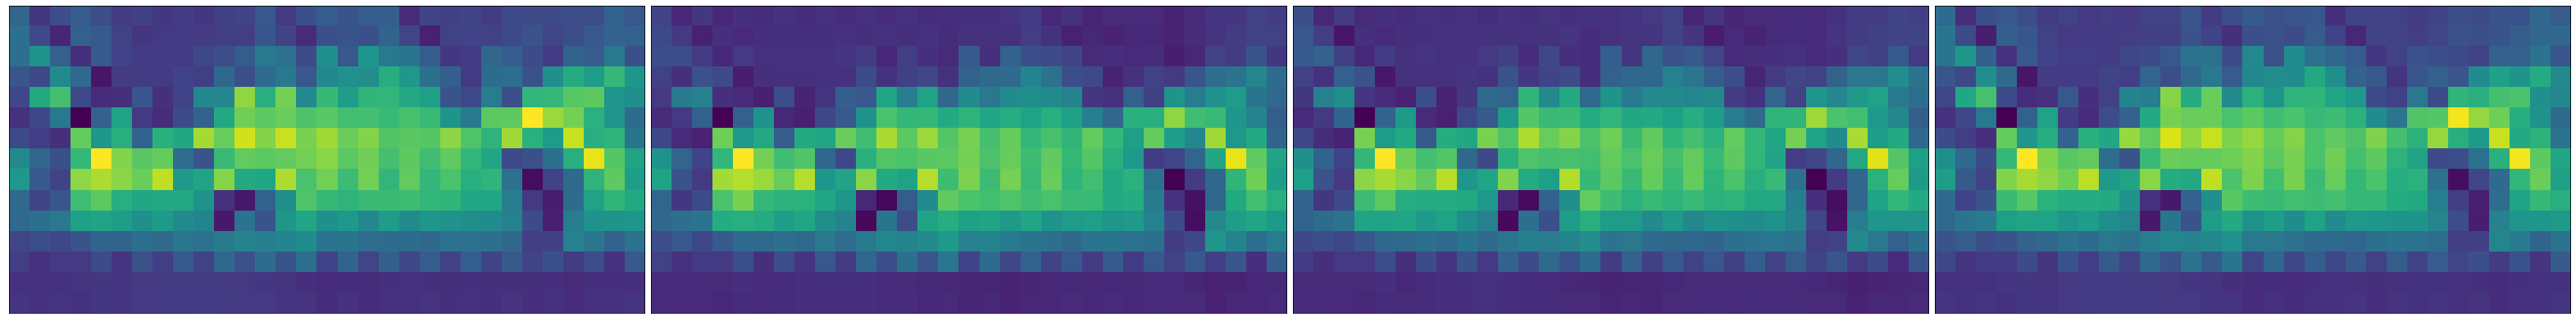

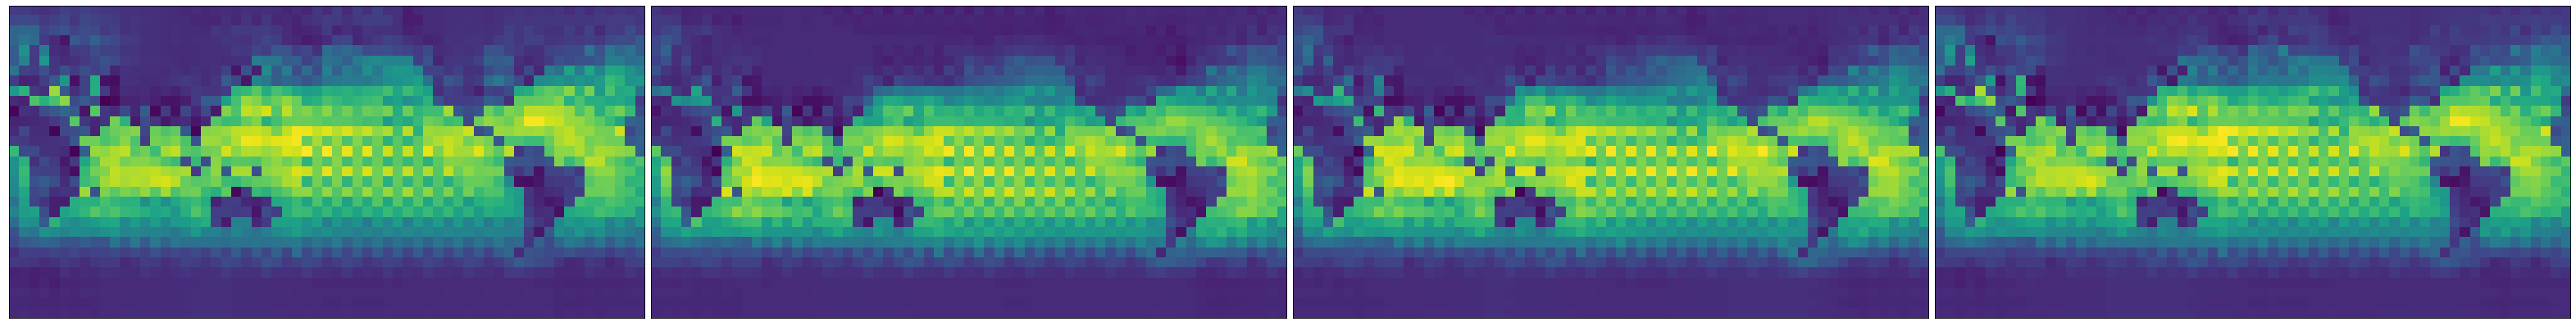

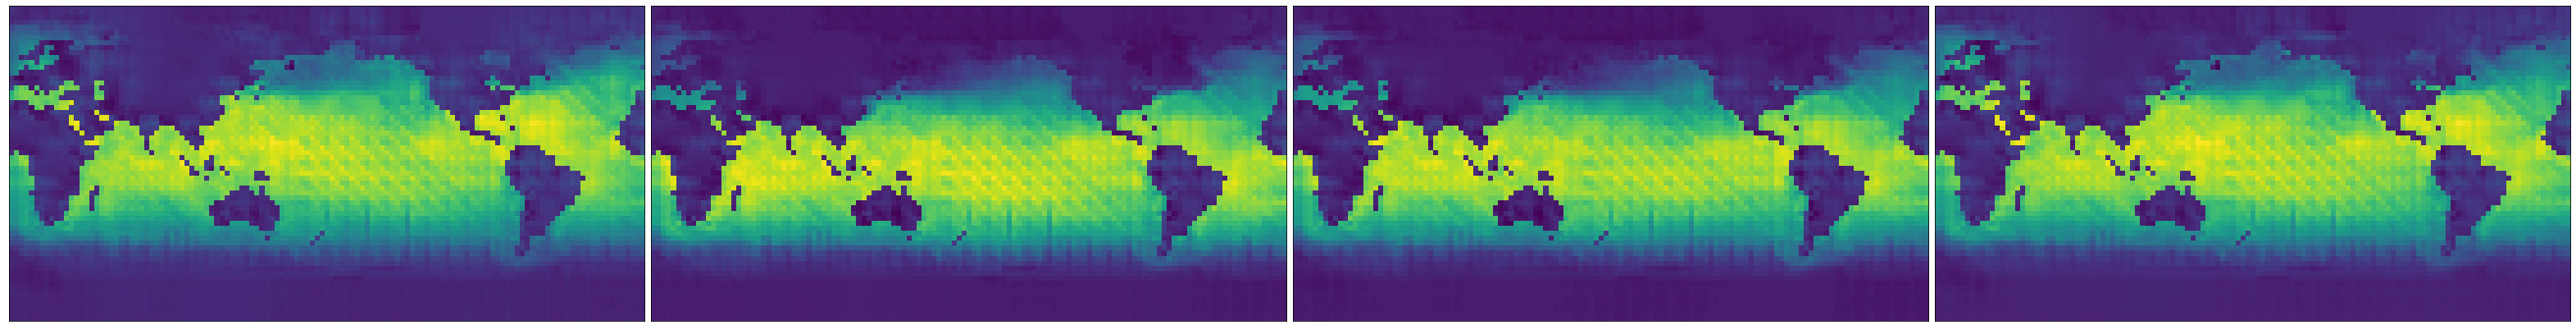

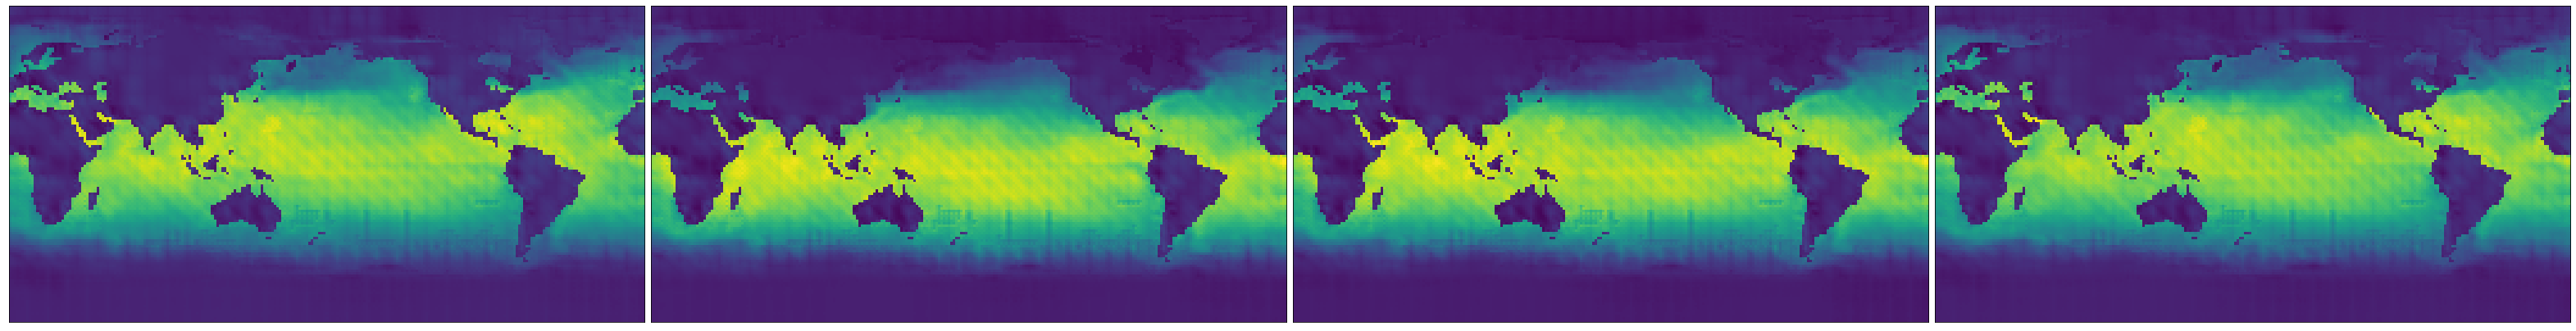

In [8]:
inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 4
n_step = n_snapshots // 4

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*14, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].imshow(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*14, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*14, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*14, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

model = models['model_L3_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*14, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=3)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L3_reconstructions.png'), bbox_inches='tight')

In [10]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        print(file_name)
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

arch.dat
best_errs.dat
max_pos_set.dat
n_params.dat
val_errs.dat


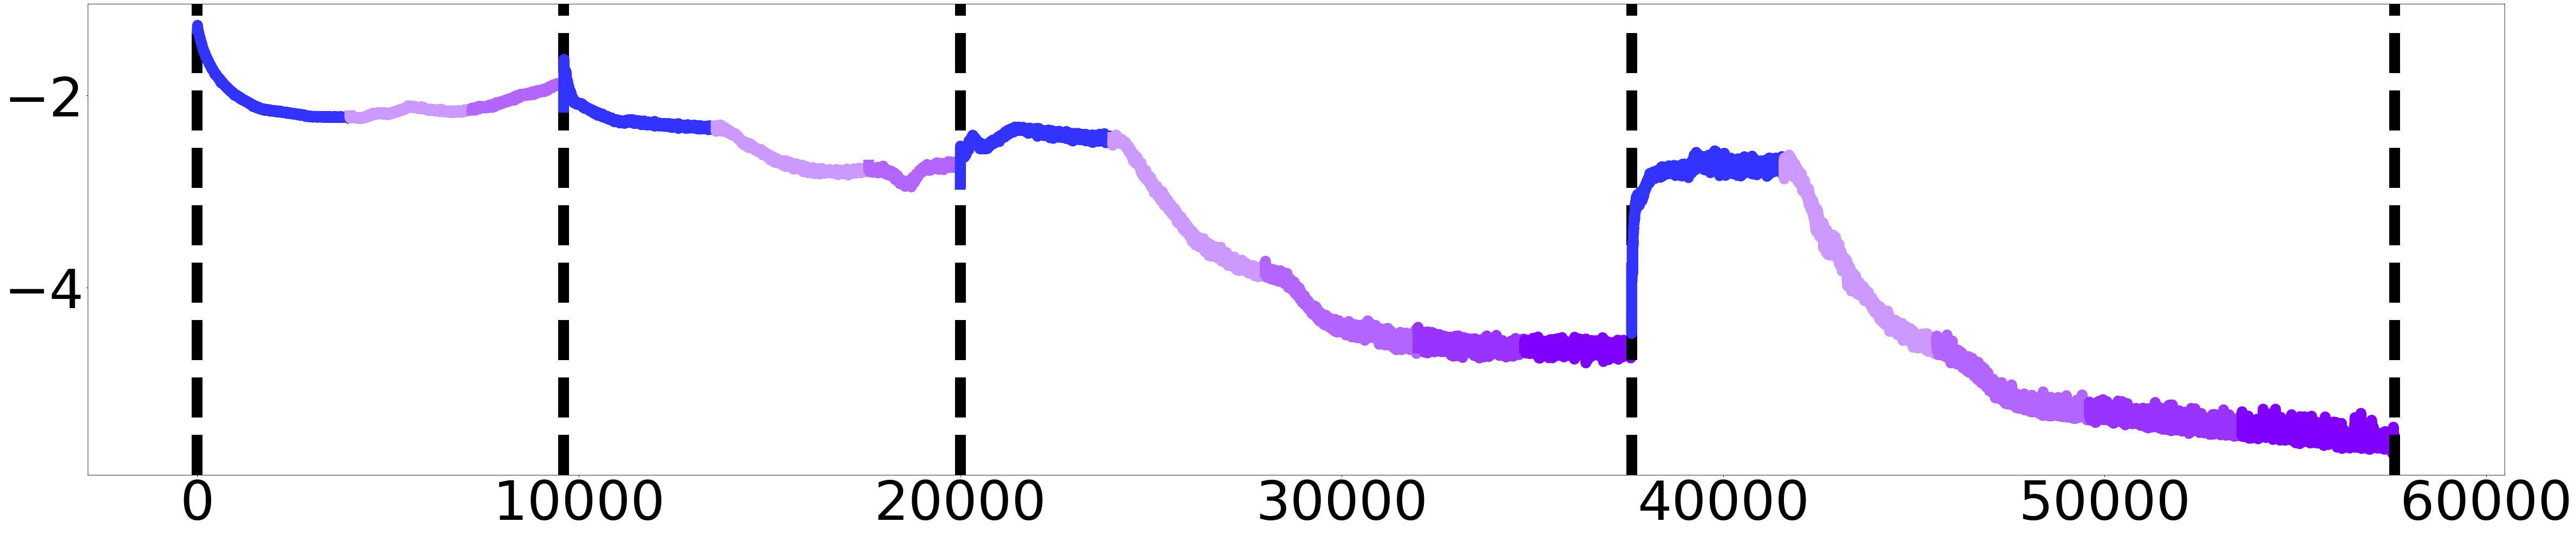

In [12]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))
# plot
s = 0
for i in range(4):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))